In [148]:
from time import perf_counter as pc

import numpy as np

from matplotlib import pyplot as plt, cm, colors

import torch
from torch import tensor, nn, optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

I borrow code and ideas from

- ["Understanding Generalization through Visuzalizations"](https://arxiv.org/abs/1906.03291) (Huang et al, 2019) in their repository [`wronnyhuang/gen-viz`](https://github.com/wronnyhuang/gen-viz)
- ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/abs/1712.09913) (Li et al, 2018) in their repository [`tomgoldstein/loss-landscape`](https://github.com/tomgoldstein/loss-landscape)

In [2]:
### Adapted from `gen-viz`
def plot_decision_boundary(model, X, train_set, test_set):
  """Predict the classification on a grid of points."""
  
  model.eval()

  xn = yn = 100
  xls = np.linspace(X[:, 0].min(), X[:, 0].max(), xn)
  yls = np.linspace(X[:, 1].min(), X[:, 1].max(), yn)

  xx1, xx2 = np.meshgrid(xls, yls)

  xstack = np.column_stack([xx1.ravel(), xx2.ravel()])
  pred = model.infer(tensor(xstack, dtype=torch.float))
  yy = np.reshape(pred, xx1.shape)

  fig, ax = plt.subplots(1, 1, figsize=(8, 8))

  # Plot decision boundary
  ax.contourf(xx1, xx2, yy, alpha=0.5, cmap="rainbow")

  # Plot train data
  train_mask = train_set[:][1] == 1
  alpha = 0.2
  ax.scatter(*train_set[:][0][train_mask].T, color="red", alpha=alpha)
  ax.scatter(*train_set[:][0][~train_mask].T, color="blue", alpha=alpha)

  # Plot test data
  test_mask = test_set[:][1] == 1
  ax.scatter(*test_set[:][0][test_mask].T, color="darkred")
  ax.scatter(*test_set[:][0][~test_mask].T, color="darkblue")

  print("dark points are test samples")
  fig.tight_layout()
  fig.show()

## Visualize data

In [13]:
### Adapted from `gen-viz`
def twospirals(n_points, noise=0.5, rng=None):
  """
    Returns the two spirals dataset.
  """
  if rng is None:
    rng = np.random.default_rng(42)

  n = np.sqrt(rng.uniform(size=(n_points, 1))) * 600 * (2*np.pi)/360
  d1x = -1.5*np.cos(n)*n + rng.uniform(size=(n_points, 1)) * noise
  d1y =  1.5*np.sin(n)*n + rng.uniform(size=(n_points, 1)) * noise
  return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

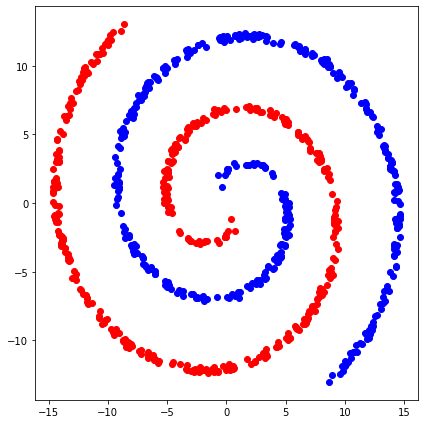

In [140]:
# Get the two spirals and plot them, colored by classification.
# I use twice as many points as Huang et al but (it seems) a little over
# half the hidden the number of hidden dimensions.
N = 400

X, Y = twospirals(N)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(*X[Y == 0].T, color="blue")
ax.scatter(*X[Y == 1].T, color="red")

fig.tight_layout()
fig.show()

## Prep dataset and dataloaders

In [84]:
class Swissroll(Dataset):
  """
    A Dataset for the points generated by `twospirals`
  """
  def __init__(self, X, Y):
    self.X, self.Y = X, Y
  
  def __len__(self): return len(self.Y)

  def __getitem__(self, idx): return self.X[idx], self.Y[idx]

In [85]:
class DataLoader_(DataLoader):
  """Convenience class that records the number of samples in the dataset."""
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    dataset = args[0]
    self.num_samples = len(dataset)

In [86]:
# Generate data and load into dataset
X, Y = twospirals(N)
dataset = Swissroll(tensor(X, dtype=torch.float), tensor(Y, dtype=torch.int64))

test_size = 0.1

train_batch_size = 16
test_batch_size = 16

# Create random split into train and test sets
random_split_rng = torch.Generator().manual_seed(42)
train_set, test_set = random_split(dataset, (1 - test_size, test_size), generator=random_split_rng)

# Create DataLoaders
train_rng = torch.Generator()
train_loader = DataLoader_(train_set, train_batch_size, shuffle=True, generator=train_rng)
test_loader = DataLoader_(test_set, test_batch_size, shuffle=False)

## Define model

In [227]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(42)

    # This appears to be what Huang et al used
    num_hidden = (23, 16, 26, 32, 28, 31)

    num_hidden = np.array([16, 16, 16, 16, 16, 16])

    relu = nn.ReLU()

    # Create ReLU-activation fully connected layers using the hidden dimensions
    layers = [[nn.Linear(prev, post), relu] for prev, post in zip(num_hidden[:-1], num_hidden[1:])]
    layers = sum(layers, [])

    self.seq = nn.Sequential(
      nn.Linear(2, num_hidden[0]), # Input data is two-dimensional
      relu,
      *layers,
      nn.Linear(num_hidden[-1], 2) # Two output classes
    )

    # Record the number of parameters for convenience
    self.num_params = sum([p.numel() for p in self.parameters() if p.requires_grad])

    # Declare the attribute here (for use by `self.record_weights` and externally)
    self.weights = None

  def forward(self, X):
    return self.seq(X)
  
  # Inspired by `gen-viz`
  def infer(self, X):
    return torch.argmax(self(X), axis=1)

  # Record the weights at a specific point in time as a reference
  def record_weights(self): self.weights = [p.data for p in self.parameters()]

  def reset_weights(self):
    """Reset the weights to those recorded in `self.weights`"""
    if self.weights is not None:
      for p, w in zip(self.parameters(), self.weights):
        p.data = w
  
print(f"number of parameters: {Model().num_params}")

number of parameters: 1442


## Train and test loops

In [88]:
def train(model, opt, num_epochs, train_loader, print_every=10):
  obj = nn.CrossEntropyLoss()
  model.train()

  # Use a different random seed every epoch but in a deterministic order
  seeds = np.arange(num_epochs)

  # Mean loss per sample
  mean_train_losses = [None] * num_epochs
  accs = [None] * num_epochs

  for epoch in range(num_epochs):
    # Set the train_loader shuffle
    train_rng.manual_seed(int(seeds[epoch]))

    epoch_loss = 0
    correct = 0
    for x, y in train_loader:
      x, y = x.to(device), y.to(device)
      opt.zero_grad()

      # Predict, get loss, backprop, step
      pred = model(x)
      loss = obj(pred, y)
      loss.backward()
      opt.step()

      epoch_loss += loss.item()
      correct += torch.sum(torch.argmax(pred, axis=1) == y).item()

    # Record mean loss per sample and mean accuracy 
    mean_train_losses[epoch] = epoch_loss / train_loader.num_samples
    accs[epoch] = correct / train_loader.num_samples

    if epoch % print_every == 0:
      print(f"epoch: {epoch:>5} | mean loss: {mean_train_losses[epoch]:.3f} | accuracy: {accs[epoch]:.3f}")
  
  return tensor(mean_train_losses), tensor(accs)

def test(model, test_loader):
  obj = nn.CrossEntropyLoss()
  model.eval()

  loss = 0
  correct = 0
  for x, y in test_loader:
    x, y = x.to(device), y.to(device)

    pred = model(x)

    loss += obj(pred, y).item()
    correct += torch.sum(torch.argmax(pred, axis=1) == y).item()

  mean_test_loss = loss / test_loader.num_samples
  test_acc = correct / test_loader.num_samples

  return mean_test_loss, test_acc

In [89]:
num_epochs = 30
lr = 1e-2
model = Model().to(device)
opt = optim.Adam(model.parameters(), lr=lr)
obj = nn.CrossEntropyLoss()

mean_train_losses, train_accs = train(model, opt, num_epochs, train_loader, print_every=10)

mean_test_loss, test_acc = test(model, test_loader)

model.record_weights()

epoch:     0 | mean loss: 0.040 | accuracy: 0.631


epoch:    10 | mean loss: 0.002 | accuracy: 0.988
epoch:    20 | mean loss: 0.000 | accuracy: 0.999


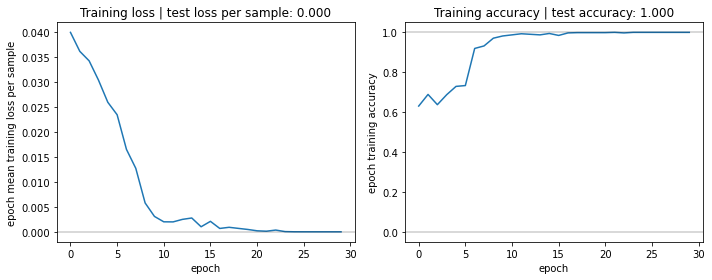

In [90]:
# Plot loss and accuracy to show model is learning
# Test loss and accuracy indicate model generalizes well
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
ax.plot(mean_train_losses)
ax.set_xlabel("epoch")
ax.set_ylabel("epoch mean training loss per sample")
ax.set_title(f"Training loss | test loss per sample: {mean_test_loss:.3f}")
ax.axhline(0, color="black", alpha=0.2)

ax = axs[1]
ax.plot(train_accs)
ax.set_xlabel("epoch")
ax.set_ylabel("epoch training accuracy")
ax.set_title(f"Training accuracy | test accuracy: {test_acc:.3f}")
ax.axhline(0, color="black", alpha=0.2)
ax.axhline(1, color="black", alpha=0.2)

fig.tight_layout()
fig.show()

## Plot decision boundary

In [91]:
### Adapted from `gen-viz`
def plot_decision_boundary(model, dataset, xls, yls, ax, shade=""):
  """Predict the classification on a grid of points on a dataset.
  
  Params:
    shade : prepended to "red" or "blue" (e.g., to indicate test set)
  """

  model.eval()

  xx1, xx2 = np.meshgrid(xls, yls)

  xstack = np.column_stack([xx1.ravel(), xx2.ravel()])
  pred = model.infer(tensor(xstack, dtype=torch.float))
  yy = np.reshape(pred, xx1.shape)

  # Plot decision boundary (only if `shade` is "", to avoid coloring the region twice)
  if shade == "":
    ax.contourf(xx1, xx2, yy, alpha=0.5, cmap="rainbow")

  # Plot dataset0
  mask = dataset[:][1] == 1
  alpha = 0.3
  ax.scatter(*dataset[:][0][mask].T, color=f"darkred", alpha=alpha)
  ax.scatter(*dataset[:][0][~mask].T, color=f"{shade}blue", alpha=alpha)

  ax.set_xlabel('$x$')
  ax.set_ylabel('$y$')

def get_xls_yls(dataset0, dataset1=None):
  """Get x- and y-linspaces. If given two datasets, make sure the linspaces accomodate both."""

  xn = yn = 100

  col = 0
  if dataset1 is not None:
    xls = np.linspace(
      min(dataset0[:][0][:, col].min(), dataset1[:][0][:, col].min()),
      max(dataset0[:][0][:, col].max(), dataset1[:][0][:, col].max()),
      xn
    )

    col = 1
    yls = np.linspace(
      min(dataset0[:][0][:, col].min(), dataset1[:][0][:, col].min()),
      max(dataset0[:][0][:, col].max(), dataset1[:][0][:, col].max()),
      yn
    )
  else:
    col = 0
    xls = np.linspace(dataset0[:][0][:, col].min(), dataset0[:][0][:, col].max(), xn)

    col = 1
    yls = np.linspace(dataset0[:][0][:, col].min(), dataset0[:][0][:, col].max(), yn)

  return xls, yls

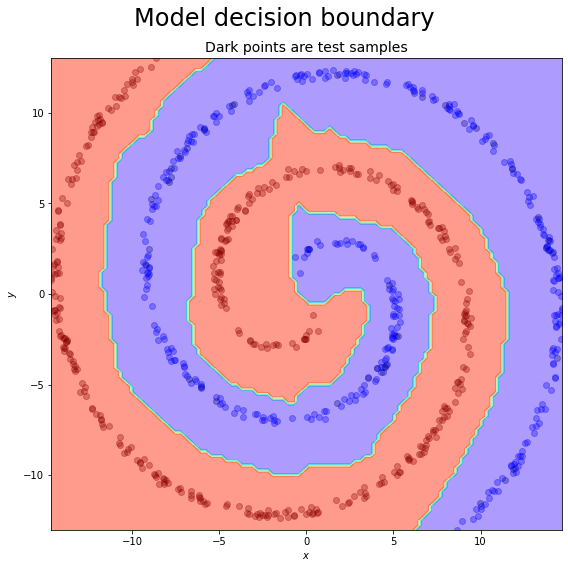

In [92]:
model.eval()

xls, yls = get_xls_yls(train_set, test_set)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

plot_decision_boundary(model, train_set, xls, yls, ax)
plot_decision_boundary(model, test_set, xls, yls, ax, "dark")

fig.suptitle("Model decision boundary", fontsize=24)
ax.set_title("Dark points are test samples", fontsize=14)

fig.tight_layout()
fig.show()

# Experiment in weightspace

## Define helper functions for weightspace and dataspace plots

- get cax to add colorbar
- get loss on an entire dataset for current weights

In [92]:
def get_cax(fig, ax, pad, width):
  """Get cax for adding a colorbar."""
  cax = fig.add_axes((
    ax.get_position().x1 + pad,
    ax.get_position().y0,
    width,
    ax.get_position().height
  ))
  return cax

def eval_on_loader(model, loader):
  """Get the loss on the entire dataset in `loadaer`."""
  model.eval()
  
  loss = 0
  for x, y in loader:
    x, y = x.to(device), y.to(device)

    # Predict, get loss, backprop, step
    pred = model(x)

    loss += obj(pred, y)
  
  return loss.item() / loader.num_samples

## Define helper functions for weightspace plots

- get random weight directions
- scale weight directions
- set model weights
- get loss on an entire dataset over region in weight space
- plot loss on train and test sets over region in weight space

In [93]:
### Adapted from `loss-landscape`
def get_random_dir_weights(weights, rng):
  """
    Produce a random direction that is a list of random Gaussian tensors
    with the same shape as the network's weights, so one direction entry per weight.
  """
  return [torch.randn(w.size(), generator=rng) for w in weights]

def get_2_random_dirs_weights(weights, rng):
  return [get_random_dir_weights(weights, rng) for _ in range(2)]

### Adapted from `loss-landscape`
def scale_dirs_weights(weights, dirs):
  """
    Set bias directions to zero (`loss-landscape` does this in their example code).
    Scale directions to have norm equal to that of the corresponding layer's weights.
  """
  for dir_i in dirs:
    for d, w in zip(dir_i, weights):
      if d.dim() <= 1:
        # Ignore biases by setting their directions to zero.
        d.fill_(0)
      else:
        d.mul_(w.norm() / d.norm())

### Adapted from `loss-landscape`
def set_weights(model, dirs, steps):
  """
    Set the weights of the model a step in each direction, i.e.,
    (new_weights = original_weights + step * direction) where original_weights
    is the value set at a given point in time by calling model.record_weights().
  """
  model.eval()

  changes = [d0 * steps[0] + d1 * steps[1] for (d0, d1) in zip(*dirs)]

  for (p, w, change) in zip(model.parameters(), model.weights, changes):
    p.data = w + change

def get_loss_surface_weightspace(model, loader, dirs, xn=50, yn=50):
  """Get the grid of loss values on the entire dataset in `loader`."""

  model.eval()

  n = xn * yn
  xls = np.linspace(-1, 1, xn)
  yls = np.linspace(-1, 1, yn)

  xsteps, ysteps = np.meshgrid(xls, yls)
  xis, yis = np.meshgrid(np.arange(xn), np.arange(yn))

  losses = np.full((yn, xn), np.inf)

  # Set the random seed of the loader even though shouldn't be necessary when using entire loader
  if loader.generator is not None:
    loader.generator.manual_seed(42)

  # xstep and ystep are the amount to step in the x- and y- weight directions
  # xi and yi are the indices in the grid of points
  for i, (xstep, ystep, xi, yi) in enumerate(zip(*map(np.ravel, (xsteps, ysteps, xis, yis)))):
    if i % 500 == 0:
      print(f"{i:>5} / {n}")
    
    set_weights(model, dirs, (xstep, ystep))

    losses[yi, xi] = eval_on_loader(model, loader)

  return xsteps, ysteps, losses

def plot_loss_surfaces_weightspace(train_losses, test_losses, xsteps, ysteps):
  """Plot the loss surfaces in weightspace on the train and test set."""

  model.eval()

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Take logs
  logtrainlosses, logtestlosses = np.log(train_losses), np.log(test_losses)
  
  cmap = cm.magma
  norm = colors.Normalize(min(logtrainlosses.min(), logtestlosses.min()),
                          max(logtrainlosses.max(), logtestlosses.max()))

  ax = axs[0]
  contour = ax.contourf(xsteps, ysteps, logtrainlosses, levels=50, norm=norm, cmap=cmap)
  ax.set_title("train")

  ax = axs[1]
  contour = ax.contourf(xsteps, ysteps, logtestlosses, levels=50, norm=norm, cmap=cmap)
  ax.set_title("test")

  [ax.set_aspect("equal") for ax in axs]

  fig.tight_layout()

  # Place the colorbar.
  pad, width = 0.02, 0.05
  cax = get_cax(fig, axs[1], pad, width)
  fig.colorbar(contour, cax=cax)

  fig.show()

## Loss surface in weightspace

### with scaling of directions

In [94]:
rng = torch.Generator().manual_seed(42)
dirs = get_2_random_dirs_weights(model.weights, rng)
scale_dirs_weights(model.weights, dirs)

xsteps, ysteps, train_losses = get_loss_surface_weightspace(model, train_loader, dirs)
xsteps, ysteps, test_losses = get_loss_surface_weightspace(model, test_loader, dirs)

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


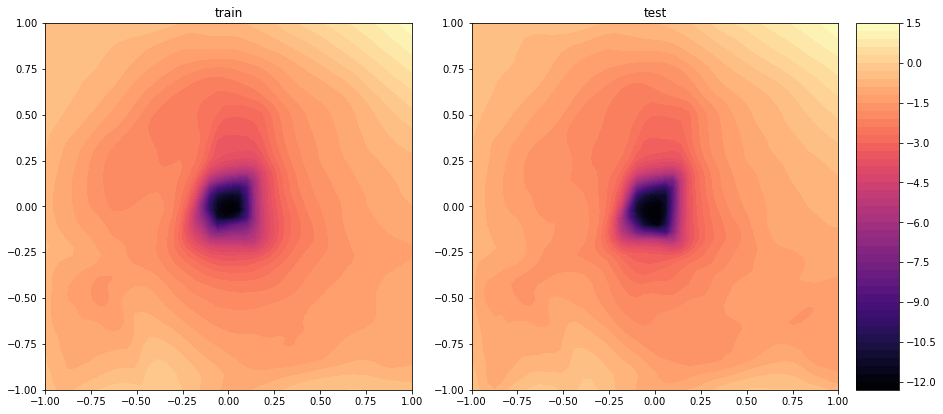

In [95]:
plot_loss_surfaces_weightspace(train_losses, test_losses, xsteps, ysteps)

### without scaling of directions

In [96]:
rng = torch.Generator().manual_seed(42)
dirs = get_2_random_dirs_weights(model.weights, rng)

xsteps, ysteps, train_losses = get_loss_surface_weightspace(model, train_loader, dirs)
xsteps, ysteps, test_losses = get_loss_surface_weightspace(model, test_loader, dirs)

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


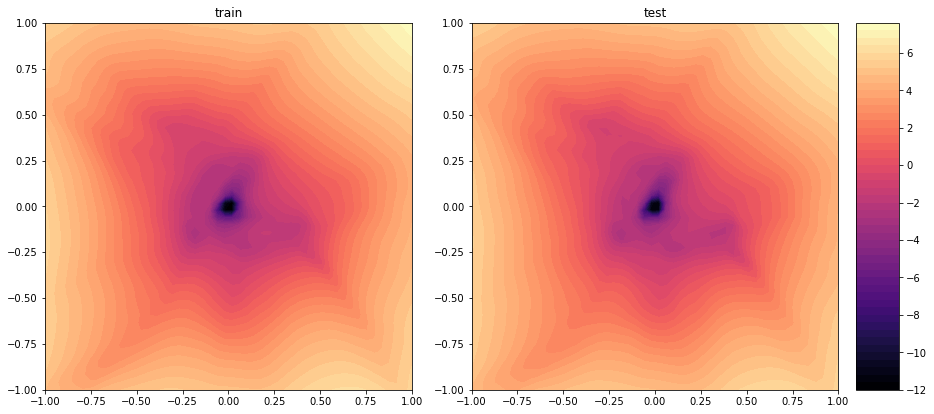

In [97]:
plot_loss_surfaces_weightspace(train_losses, test_losses, xsteps, ysteps)

# Experiment in data-space

## Define helper functions for dataspace plots

- get random data directions
- scale data directions
- create pertubed dataset using directions and steps
- create pertubed dataloader using directions and steps
- get loss on an entire (potentially perturbed) dataset
- plot loss on entire dataset, perturbed in two random directions

In [118]:
def get_random_dir_data(dataset, rng):
  """Create a random direction that is the same shape as the dataset,
  so one entry per scalar value."""

  return torch.randn(dataset[:][0].size(), generator=rng)

def get_2_random_dirs_data(dataset, rng):
  return [get_random_dir_data(dataset, rng) for _ in range(2)]

def scale_dirs_data(dataset, dir_i, dim):
  """
    Inspired Li et al, scale the random dataspace directions.

    dim = 0 : scale by feature:
      e.g., if data has x- and y-coordinates (i.e. is two-dimensional),
        scale the x-coordinates of the direction to have the same norm as the x-coordinates
        of the data, and
        scale the y-coordinates of the direction to have the same norm as the y-coordinates
        of the data
    dim = 1 : scale by datapoint:
      e.g., if their are 3 samples,
        scale the direction corresponding to the first sample to have the same norm as the
        first sample in the data,
        scale the direction corresponding to the second sample to have the same norm as the
        second sample in the data, and
        do the same for third direction/sample
    dim = -1 (or anything else): do nothing
  """
  for dir_i in dirs:
    if dim == 0:
      dir_i.mul_(dataset[:][0].norm(dim=dim) / dir_i.norm(dim=dim))
    elif dim == 1:
      # Note the tranpsose to make the dimensions behave
      dir_i.T.mul_(dataset[:][0].norm(dim=dim) / dir_i.norm(dim=dim))

def get_perturbed_dataset(dataset, dirs, steps):
  """Create a new dataset by perturbing the original in the given directions and 
  by the given steps."""
  
  data = dataset[:][0]

  perturbed_data = data + dirs[0] * steps[0] + dirs[1] * steps[1]
  perturbed_dataset = Swissroll(perturbed_data, dataset[:][1])

  return perturbed_dataset

def get_perturbed_loader(dataset, dirs, steps, batch_size):
  """Create a new dataloader by perturbing the original in the given directions and 
  by the given steps."""

  perturbed_dataset = get_perturbed_dataset(dataset, dirs, steps)
  perturbed_loader = DataLoader_(perturbed_dataset, batch_size, shuffle=False)

  return perturbed_loader

def get_loss_surface_dataspace(model, dataset, dirs, batch_size=train_batch_size, xn=50, yn=50):
  """Get the grid of loss values on the entire (potentially perturbed) dataset in `loader`."""

  model.eval()

  n = xn * yn
  xls = np.linspace(-1, 1, xn)
  yls = np.linspace(-1, 1, yn)

  xsteps, ysteps = np.meshgrid(xls, yls)
  xis, yis = np.meshgrid(np.arange(xn), np.arange(yn))

  losses = np.full((yn, xn), np.inf)

  for i, (xstep, ystep, xi, yi) in enumerate(zip(*map(np.ravel, (xsteps, ysteps, xis, yis)))):
    if i % 500 == 0:
      print(f"{i:>5} / {n}")
    
    perturbed_loader = get_perturbed_loader(dataset, dirs, (xstep, ystep), batch_size)

    losses[yi, xi] = eval_on_loader(model, perturbed_loader)

  return xsteps, ysteps, losses

def plot_loss_surface_dataspace(train_losses, xsteps, ysteps):
  """Plot the loss surfaces in dataspace on the train set (i.e., perturbed in two random directions)."""

  model.eval()

  fig, ax = plt.subplots(1, 1, figsize=(6, 6))

  # Take the log
  logtrainlosses = np.log(train_losses)

  cmap = cm.magma
  norm = colors.Normalize(logtrainlosses.min(), logtrainlosses.max())

  contour = ax.contourf(xsteps, ysteps, logtrainlosses, levels=50, norm=norm, cmap=cmap)

  ax.set_aspect("equal")

  fig.tight_layout()

  # Place colorbar
  pad, width = 0.02, 0.05
  cax = get_cax(fig, ax, pad, width)
  fig.colorbar(contour, cax=cax)

  fig.show()

## Loss surfaces in dataspace

### Without scaling random dataspace directions

In [158]:
dim = -1

model.eval()

rng = torch.Generator().manual_seed(42)
dirs = get_2_random_dirs_data(train_set, rng)
scale_dirs_data(train_set, dirs, dim=dim)

model.reset_weights()
xsteps, ysteps, train_losses = get_loss_surface_dataspace(model, train_set, dirs)

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


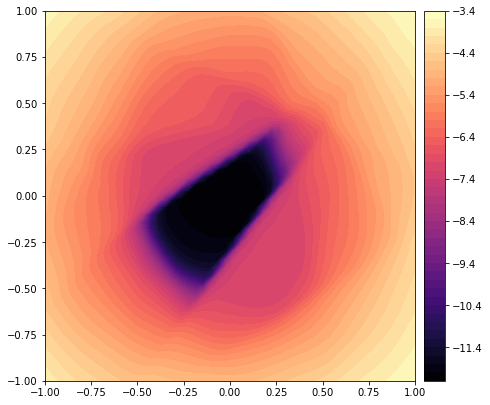

In [159]:
plot_loss_surface_dataspace(train_losses, xsteps, ysteps)

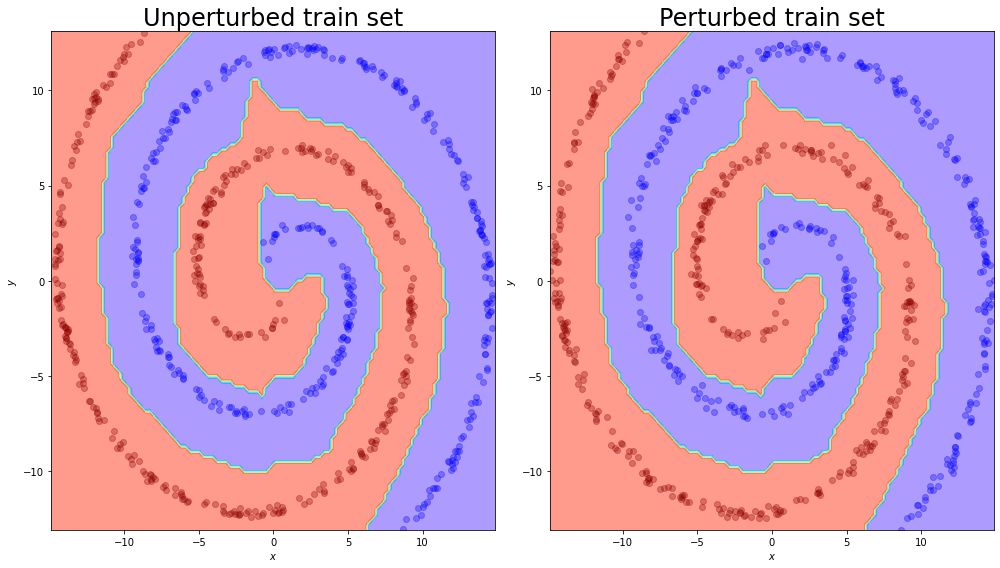

In [160]:
steps = 0.1, 0.1
perturbed_dataset = get_perturbed_dataset(train_set, dirs, steps)

xls, yls = get_xls_yls(train_set, perturbed_dataset)

fig, axs = plt.subplots(1, 2, figsize=(14, 8))

ax = axs[0]
plot_decision_boundary(model, train_set, xls, yls, ax)
ax.set_title("Unperturbed train set", fontsize=24)

ax = axs[1]
plot_decision_boundary(model, perturbed_dataset, xls, yls, ax)
ax.set_title("Perturbed train set", fontsize=24)

fig.tight_layout()
fig.show()

### With scaling random dataspace directions by features

(see docstring on scale_data_dirs)

In [161]:
dim = 0

rng = torch.Generator().manual_seed(42)
dirs = get_2_random_dirs_data(train_set, rng)
scale_dirs_data(train_set, dirs, dim=dim)

model.reset_weights()
xsteps, ysteps, train_losses = get_loss_surface_dataspace(model, train_set, dirs)

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


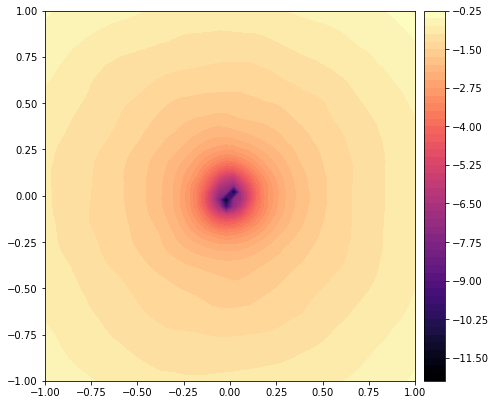

In [162]:
plot_loss_surface_dataspace(train_losses, xsteps, ysteps)

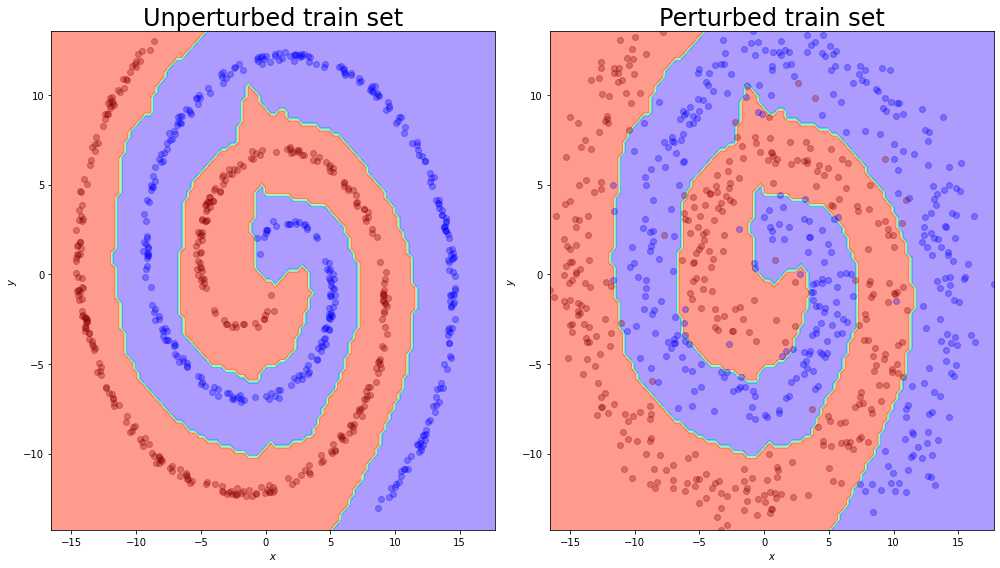

In [163]:
steps = 0.1, 0.1
perturbed_dataset = get_perturbed_dataset(train_set, dirs, steps)

xls, yls = get_xls_yls(train_set, perturbed_dataset)

fig, axs = plt.subplots(1, 2, figsize=(14, 8))

ax = axs[0]
plot_decision_boundary(model, train_set, xls, yls, ax)
ax.set_title("Unperturbed train set", fontsize=24)

ax = axs[1]
plot_decision_boundary(model, perturbed_dataset, xls, yls, ax)
ax.set_title("Perturbed train set", fontsize=24)

fig.tight_layout()
fig.show()

### With scaling random dataspace directions by datapoints

(see docstring on scale_data_dirs)

In [164]:
dim = 1

rng = torch.Generator().manual_seed(42)
dirs = get_2_random_dirs_data(train_set, rng)
scale_dirs_data(train_set, dirs, dim=dim)

model.reset_weights()
xsteps, ysteps, train_losses = get_loss_surface_dataspace(model, train_set, dirs)

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


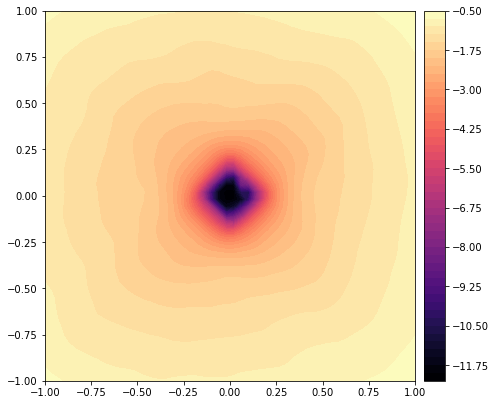

In [165]:
plot_loss_surface_dataspace(train_losses, xsteps, ysteps)

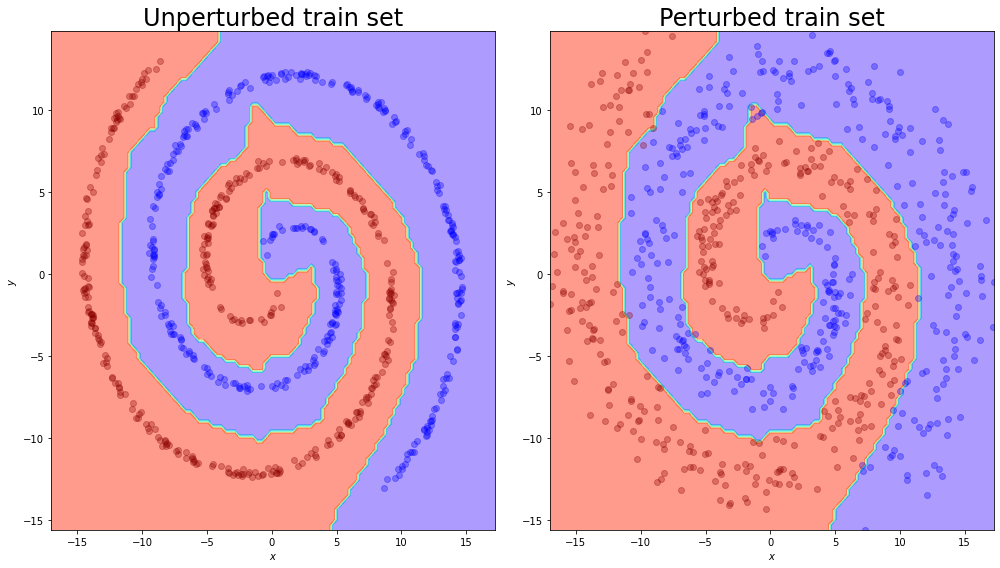

In [166]:
steps = 0.1, 0.1
perturbed_dataset = get_perturbed_dataset(train_set, dirs, steps)

xls, yls = get_xls_yls(train_set, perturbed_dataset)

fig, axs = plt.subplots(1, 2, figsize=(14, 8))

ax = axs[0]
plot_decision_boundary(model, train_set, xls, yls, ax)
ax.set_title("Unperturbed train set", fontsize=24)

ax = axs[1]
plot_decision_boundary(model, perturbed_dataset, xls, yls, ax)
ax.set_title("Perturbed train set", fontsize=24)

fig.tight_layout()
fig.show()

# TODO

1. Compare sharper and flatter minimizers in weight- and dataspace (try poisoning data to artificially create such minimizers?)
1. Try on MNIST?

... The paper I take the swiss roll from shows that poisoned data leads to sharper minimizers. By putting poisoned data in, we force the decision boundary to be close to the points rather than have a "wide margin," and this leads to a sharper minimizer, at least empirically. Does the reverse hold? That is, does a sharper minimizer necessarily mean that the margin is narrow? How does this look in higher dimensions (other than a 2D swiss roll), where the decision boundary isn't easily seen?

# Work with poisoned data

## Prep poisoned data

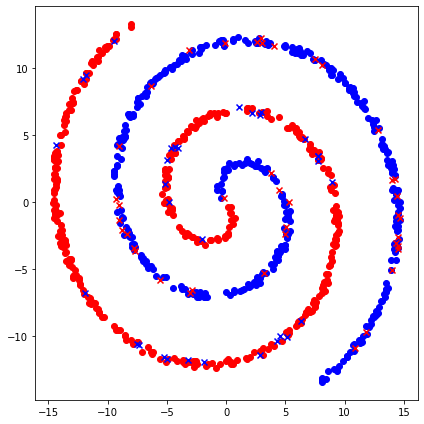

In [213]:
test_size = 0.1
poison_factor = 1/10

# Generate clean and to-be-poisoned points.
Xall, Yall = twospirals(N*2)

clean_poison_split_rng = torch.Generator().manual_seed(42)
all_dataset = Swissroll(tensor(Xall, dtype=torch.float), tensor(Yall, dtype=torch.int64))

# Randomly partition into clean and poisoned data. Make the proportions 1/2 and 1/2
# so we can take the right proportions later.
clean, poison = random_split(all_dataset, (1/2, 1/2), generator=random_split_rng)

# Scale the number of poisoned samples by the train size, (1 - test_size),
# since the clean dataset will be partitioned into train and test sets.
num_poison = int(poison_factor * len(poison) * (1 - test_size))
poison = Swissroll(poison[: num_poison][0], 1 - poison[: num_poison][1])

# Clean data
X, Y = clean[:][0], clean[:][1]

# Poisoned data
Xp, Yp = poison[:][0], poison[:][1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Clean data
ax.scatter(*X[Y == 0].T, color="blue")
ax.scatter(*X[Y == 1].T, color="red")

# Poisoned data
ax.scatter(*Xp[Yp == 0].T, color="blue",  marker='x')
ax.scatter(*Xp[Yp == 1].T, color="red",  marker='x')

fig.tight_layout()
fig.show()

In [214]:
train_batch_size = 16
test_batch_size = 16

# Create random split of clean data into train and test sets
random_split_rng = torch.Generator().manual_seed(42)
clean_train_set, test_set = random_split(clean, (1 - test_size, test_size), generator=random_split_rng)

# Concatenate clean_train_set and poisoned dataset (the DataLoader shuffle will mix them)
num_clean = int((1 - poison_factor) * len(clean_train_set))
train_set = Swissroll(
  torch.cat((clean_train_set[: num_clean][0], poison[:][0])),
  torch.cat((clean_train_set[: num_clean][1], poison[:][1]))
)
  
# Create DataLoaders
train_rng = torch.Generator()

train_loader = DataLoader_(train_set, train_batch_size, shuffle=True, generator=train_rng)
test_loader = DataLoader_(test_set, test_batch_size, shuffle=False)

## Train on poisoned data

In [228]:
num_epochs = 30
lr = 1e-2
model = Model().to(device)
opt = optim.Adam(model.parameters(), lr=lr)
obj = nn.CrossEntropyLoss()

mean_train_losses, train_accs = train(model, opt, num_epochs, train_loader, print_every=10)

mean_test_loss, test_acc = test(model, test_loader)

model.record_weights()

epoch:     0 | mean loss: 0.042 | accuracy: 0.579
epoch:    10 | mean loss: 0.029 | accuracy: 0.839
epoch:    20 | mean loss: 0.031 | accuracy: 0.786


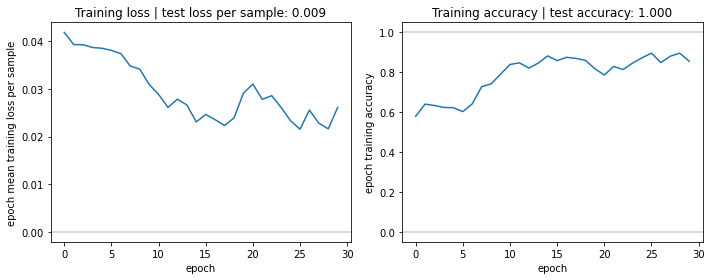

In [229]:
# Plot loss and accuracy to show model is learning
# Test loss and accuracy indicate model generalizes well
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
ax.plot(mean_train_losses)
ax.set_xlabel("epoch")
ax.set_ylabel("epoch mean training loss per sample")
ax.set_title(f"Training loss | test loss per sample: {mean_test_loss:.3f}")
ax.axhline(0, color="black", alpha=0.2)

ax = axs[1]
ax.plot(train_accs)
ax.set_xlabel("epoch")
ax.set_ylabel("epoch training accuracy")
ax.set_title(f"Training accuracy | test accuracy: {test_acc:.3f}")
ax.axhline(0, color="black", alpha=0.2)
ax.axhline(1, color="black", alpha=0.2)

fig.tight_layout()
fig.show()

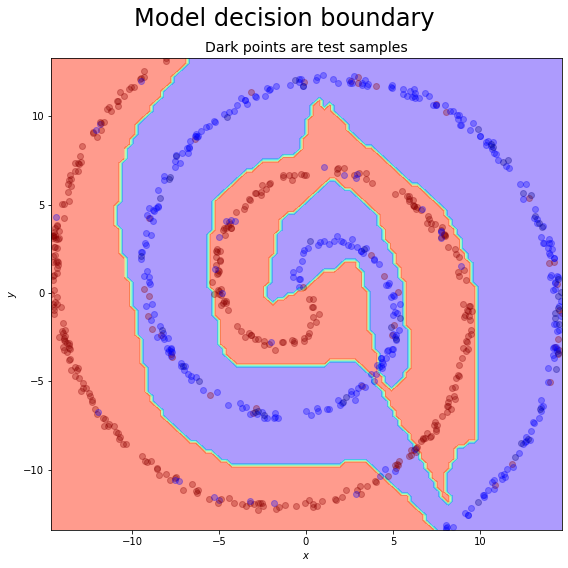

In [230]:
model.eval()

xls, yls = get_xls_yls(train_set, test_set)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

plot_decision_boundary(model, train_set, xls, yls, ax)
plot_decision_boundary(model, test_set, xls, yls, ax, "dark")

fig.suptitle("Model decision boundary", fontsize=24)
ax.set_title("Dark points are test samples", fontsize=14)

fig.tight_layout()
fig.show()